In [55]:
import pandas as pd
import numpy as np
import regex as re
from tqdm import tqdm
import functools
import operator
import math
import nltk
from nltk.corpus import stopwords
from collections import Counter, defaultdict
from scipy.sparse import dok_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [4]:
def tokenize(words):
    '''Takes in a string and tokenizes it by whitespace,
and returns a list of tokens.
    '''
    return words.split(' ')

In [5]:
# A test of our first function
tokenize('hi i am brendan')

['hi', 'i', 'am', 'brendan']

It looks like it would work for simple sentences, but having different punctuations and cases would be a tough look. Let's see if it would fail with the sentence "Good, that is good."

In [6]:
tokenize('Good, I am good.')

['Good,', 'I', 'am', 'good.']

Issues are capitalization and punctuation. Let's try to fix those in the tokenize.better function. Also, we want to keep apostrophes because of possible possessive words and contractions. Also, removing stop words might be important because those don't contribute to our analysis at all! 

In [7]:
def better_tokenize(words):
    '''
    The difference here is that I am using regex to get rid of all punctuation,
    except apostrophe and then making everything lowercase. 
    Only then can I split based on the whitespace. Basically the 
    regex says sub everything that's not whitespace
    and alphanumeric or apostrophe with nothing. Then drop stop words
    '''
    stopper = stopwords.words('english')
    words = re.sub(r"[^\w\d'\s]", '', words ).lower().split(' ')
    return [word for word in words if word not in stopper]
    


Now to test it on the first line of the bee movie for fun

In [8]:
better_tokenize("According to all known laws of aviation, there is no way a bee should be able to fly.")

['according', 'known', 'laws', 'aviation', 'way', 'bee', 'able', 'fly']

Looks like it works, it took the important words out of that phrase!

Time to make the Scipy Sparse Matrix!

In [9]:
practice_str = "My Name is Brendan, and I am a person, a person who knows his name"
# so basically, if the sparse matrix has min freq of 2, we should see 
# person and name in our sparse matrix.

It might be useful to use our tokenize function here to parse this sentence

In [10]:
better_tokenize(practice_str)

['name', 'brendan', 'person', 'person', 'knows', 'name']

So we can see that this picked up on name and person, as we predicted

Now, to use the Counter functionality to count how much a specific word occurs

In [11]:
Counter(better_tokenize(practice_str))

Counter({'name': 2, 'brendan': 1, 'person': 2, 'knows': 1})

Since the code only wants occurences of 2+, let's just keep those

In [12]:
Counter(better_tokenize(practice_str))['name']

2

In [13]:
Counter(better_tokenize(practice_str))

Counter({'name': 2, 'brendan': 1, 'person': 2, 'knows': 1})

In [14]:
counts = defaultdict(int)
wordcounts = Counter(better_tokenize(practice_str))
for word in set(wordcounts):
    if wordcounts[word] >= 2:
        counts[word] += wordcounts[word]

In [15]:
train = pd.read_csv('si630w23-hw1.train.csv')
train.text = train.text.apply(better_tokenize)
train

,text,sarcastic
0,"[thing, got, college, caffeine, addiction]",1
1,"[love, professors, draw, big, question, mark, ...",1
2,"[remember, hundred, emails, companies, covid, ...",1
3,"[today, poppop, told, forced, go, college, , o...",1
4,"[volphancarol, littlewhitty, mysticalmanatee, ...",1
...,...,...
3462,"[population, spike, chicago, 9, months, ridicu...",0
3463,"[think, second, last, english, class, year, pr...",0
3464,"[im, finally, surfacing, holiday, scotland, di...",0
3465,"[prouder, today, well, done, every, student, g...",0


Generate a list of unique words in the training set for our vocab

In [16]:
train_vocab_all = functools.reduce(operator.iconcat, 
                list(train['text']), [])
len(train_vocab_all)

37174

In [409]:
c = Counter(train_vocab_all)
to_remove = {x for x, i in c.items() if i < 2}
train_vocab = list(set(train_vocab_all) - to_remove)
len(train_vocab)

3844

In [18]:
S = dok_matrix((len(train), len(train_vocab)+1), dtype=int)

for i in tqdm(range(len(train))):
    #get the text for specific row
    text_set = set(train.text.loc[i])

    for j in range(len(train_vocab)):

        word = train_vocab[j]
        if word in text_set:

            S[i, j] += 1    # Update element
    # add bias term
    S[i,len(train_vocab)] += 1

100%|██████████| 3467/3467 [00:03<00:00, 1058.49it/s]


How many items in our matrix are ones?

In [19]:
S.sum()

32211

In [20]:
S.sum()/(len(train)*len(train_vocab))

0.002416946221352085

** Part 2 **

In [21]:
def sigmoid(X):
    return 1/(1+math.e**(-X))

Putting it all together, write a function logistic regression that takes in a
– a matrix X where each row is a vector that has the features for that instance
– a vector Y containing the class of the row
– learning rate which is a parameter to control how much you change the β values
each step
– num step how many steps to update β before stopping

In [23]:
S.shape[1]

3845

From the scatterplot, it looks like it is consistenly moving in the right direction!

We can see that the model is inching towards the right direction -- the log likelihood is increasing every time. Now what if we try a stronger learning rate?

In [121]:
#version 2 (so far)


def log_likelihood_2(betas, data, is_sarcastic):
    dot_product = data @ betas
    # is_sarcastic is a vector with all the predictions
    #data.T * (is_sarcastic - sigmoid(dot_product))
    #multiply out to get a vector?
    # sum of the vector
    return sum(data.T * (is_sarcastic - sigmoid(data @ betas)))

def compute_gradient_2(beta, xrow, truelabel):
    dot_product = xrow @ beta
    prediction = sigmoid(dot_product)
    return (truelabel - prediction) * xrow
    #scalar for direction for mistake, xrow how to change feature values


def logisitic_regression_2(X, Y, learning_rate, num_step):
    list_of_likelihoods = []
    # establish betas as vector of zeros
    betas = np.random.rand(X.shape[1])

    #run this loop
    for i in tqdm(range(num_step)):
        #pick a random row
        index = np.random.randint(X.shape[0])

        #get the classification value from our Y
        classification = Y[index]

        loglikelihood = log_likelihood_2(betas,X, train.sarcastic)
        gradient = compute_gradient_2(betas,X[index], classification)

        #betas_to_change = [j for i,j in list(X[0].keys())]

        list_of_likelihoods.append(loglikelihood)

        
        betas += (learning_rate * gradient)

    return betas, list_of_likelihoods   


In [120]:
np.random.rand(S.shape[1])

array([0.04214918, 0.20084244, 0.41348536, ..., 0.6339651 , 0.8501566 ,
       0.44089808])

In [122]:
X = S
Y = train.sarcastic
learning_rate = 5e-5
num_step = 1000
result = logisitic_regression_2(X, Y, learning_rate, num_step)
result

100%|██████████| 1000/1000 [00:58<00:00, 17.11it/s]


(array([0.87293061, 0.29633658, 0.02919041, ..., 0.5713144 , 0.99217158,
        0.66163122]),
 [-23683.98987356017,
  -23683.98990783441,
  -23683.963990494285,
  -23683.935550288363,
  -23683.91026020764,
  -23683.884244831672,
  -23683.858881135002,
  -23683.860230421986,
  -23683.836433271717,
  -23683.8109757681,
  -23683.785944604555,
  -23683.78594526189,
  -23683.78786088028,
  -23683.76249298192,
  -23683.762575093984,
  -23683.73184529952,
  -23683.706240717707,
  -23683.68276327817,
  -23683.6835943895,
  -23683.68361409432,
  -23683.685121584418,
  -23683.686436203214,
  -23683.663607088085,
  -23683.635423375596,
  -23683.607442514152,
  -23683.581596516124,
  -23683.555830055284,
  -23683.529527614563,
  -23683.529727236284,
  -23683.502533678813,
  -23683.473503221678,
  -23683.475578903992,
  -23683.44979629621,
  -23683.42380255166,
  -23683.423812806923,
  -23683.394611130007,
  -23683.368795988765,
  -23683.36892391192,
  -23683.368971326137,
  -23683.343977628,
  -2

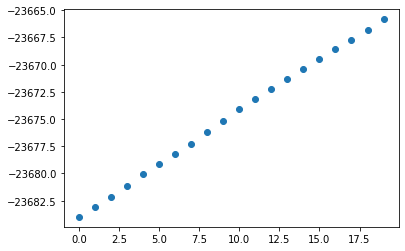

In [123]:
plt.scatter(x = list(range(len(result[1][::50]))), y = result[1][::50])

It looks like this converges to 1 inevitably (I think this is good?) 
In the first graph, it doesn't converge quite yet, but I think that is because of the small learning rate.

After training on the training data, use your logistic regression classifier to make predictions
on the validation dataset and report your performance using the F1 score.

First, we have to make the `predict` function..

given some new text, converts it to a vector (i.e., something
like a row from X), and then uses the β vector to predict the class and returns the class label.

In [34]:
betas = result[0]
def predict(text, beta_vector = betas):
    tokenized = better_tokenize(text)
    indices_list = []
    
    for word in tokenized:
        if word in train_vocab:
            indices_list.append(train_vocab.index(word))
    betas_list = [betas[index] for index in indices_list]
    prob = sum(x * y for x, y in zip(indices_list, betas_list))
    #print(prob)
    if sigmoid(prob) >= 0.5:
        return 1
    elif sigmoid(prob) < 0.5:
        return 0 
    

Let's tune this model up a little bit

In [124]:
X = S
Y = train.sarcastic
learning_rate_2 = 1e-6
learning_rate_3 = 1e-4
learning_rate_4 = 1e-2
num_step = 5000
result_2 = logisitic_regression_2(X, Y, learning_rate_2, num_step)
result_3 = logisitic_regression_2(X, Y, learning_rate_3, num_step)
result_4 = logisitic_regression_2(X, Y, learning_rate_4, num_step)

100%|██████████| 5000/5000 [04:51<00:00, 17.13it/s]


Now let's see how this log likelihood would change every 50

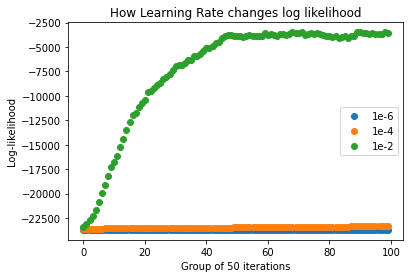

In [125]:
for result in [result_2, result_3, result_4]:
    plt.scatter(x = list(range(len(result[1][::50]))), y = result[1][::50])
plt.title('How Learning Rate changes log likelihood')
plt.xlabel('Group of 50 iterations')
plt.ylabel('Log-likelihood')
plt.legend(['1e-6','1e-4','1e-2'], loc = "right")
plt.show()

I like the learning rate of 1e-2 a lot, let's see what happens when we mess with 1e-2, 5e-2, and 1e-1

In [132]:
X = S
Y = train.sarcastic
learning_rate_5 = 1e-1
learning_rate_6 = 5e-2
num_step = 5000
result_5 = logisitic_regression_2(X, Y, learning_rate_5, num_step)
result_6 = logisitic_regression_2(X, Y, learning_rate_6, num_step)


100%|██████████| 5000/5000 [04:52<00:00, 17.11it/s]


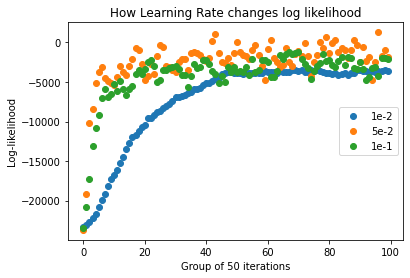

In [134]:
for result in [result_4, result_5, result_6]:
    plt.scatter(x = list(range(len(result[1][::50]))), y = result[1][::50])
plt.title('How Learning Rate changes log likelihood')
plt.xlabel('Group of 50 iterations')
plt.ylabel('Log-likelihood')
plt.legend(['1e-2','5e-2','1e-1'], loc = "right")
plt.show()

We can see here that the model improves radidly when the learning rate changes 

In [138]:
dev = pd.read_csv('si630w23-hw1.dev.csv')
predictions = []
for i in dev.text:
    predictions.append(predict(i, beta_vector = result_5[0]))

In [139]:
dev['predictions'] = predictions
dev

,text,sarcastic,predictions
0,I believe that Britain’s international reputat...,0,0
1,sometimes it seems like there’s nothing to do ...,0,0
2,"if you listen carefully, you can hear me not c...",1,0
3,"Aha, my thoughts exactly. We are on which day ...",0,0
4,Aidan Coleman what a man 💪💪 Well spoken,0,1
...,...,...,...
275,"""This Christmas I hope you all either get vacc...",0,0
276,Great Welsh Karaoke Rewrites (pt 94): 'Cyfarth...,0,0
277,I see all the reasons Mark has put forward and...,0,0
278,What a stupid take on football this is 😂😂😂,0,0


Compute accuracy!

In [140]:
f1_score(dev.sarcastic, dev.predictions)

0.0

In [472]:
test_preds_numpy = []
test = pd.read_csv('si630w23-hw1.test.csv')
for i in test.text:
    test_preds_numpy.append(predict(i, beta_vector = result_5[0]))

In [473]:
test_preds_np = pd.DataFrame()
test_preds_np['Index'] = list(range(len(test_preds_numpy)))
test_preds_np['prediction'] = test_preds_numpy
test_preds_np.to_csv('test_predictions_numpy.csv')

** PART 2 **

First. create the function to convert our sparse matrices to the tensor object.

In [86]:
def to_sparse_tensor(matrix):
    matrix = matrix.asformat("coo")
    return (torch.sparse.FloatTensor(
                        torch.LongTensor(np.vstack((matrix.row, matrix.col))),
                        torch.FloatTensor(matrix.data), 
                        torch.Size(matrix.shape))
                        .to_dense())
    

In [269]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim, vocab_size = len(train_vocab), optimizer = None):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        if not optimizer:
            self.optimizer  = optimizer


    def forward(self,data):
        return torch.sigmoid(self.linear(data))
        




In [339]:
# let's get this thing up and running!
model = LogisticRegression(input_dim= T.shape[1],
                            output_dim= 1)

# define loss function
criterion = nn.BCELoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)

T = dok_matrix((len(train), len(train_vocab)), dtype=int)

for i in tqdm(range(len(train))):
    #get the text for specific row
    text_set = set(train.text.loc[i])

    for j in range(len(train_vocab)):

        word = train_vocab[j]
        if word in text_set:

            T[i, j] += 1    # Update element


T = to_sparse_tensor(T)

dev_matrix = dok_matrix((len(dev), len(train_vocab)), dtype = np.int64)
for i in range(len(dev)):
    text = dev.iloc[i,0]
    list_of_words = better_tokenize(text)
    for word in list_of_words:
        if word in train_vocab:
            dev_matrix[i,train_vocab.index(word)] +=1

dev_matrix = to_sparse_tensor(dev_matrix)
y = torch.Tensor(train.sarcastic)
loss_vector = []
f1_list = []
for i in tqdm(range(10)):
    
    steps = 0
    rng_jesus = np.arange(T.shape[0])
    np.random.shuffle(rng_jesus)
    for i in range(T.shape[0]):
        steps+=1
        model.train()

        #random row
        index = rng_jesus[i]

        #data
        x_sample = T[index]
        y_sample = y[index]

        # zero gradients
        optimizer.zero_grad()

        #Forward pass
        y_hat = model(x_sample)



        #compute loss..
        loss = criterion(y_hat.squeeze(), y_sample)


        #Backward step
        loss.backward()

        if steps % 50 == 0:
            model.eval()

            with torch.no_grad():
                #append the loss vector
                #loss_vector.append(loss.item())
                y_hat = model(dev_matrix)
                loss = criterion(y_hat.squeeze(), torch.Tensor(dev.sarcastic))
                loss_vector.append(loss.item())
                f1_list.append(f1_score(y_hat.round().squeeze(), torch.Tensor(dev.sarcastic)))




        optimizer.step()
        # Update loss vector
        


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


<AxesSubplot:>

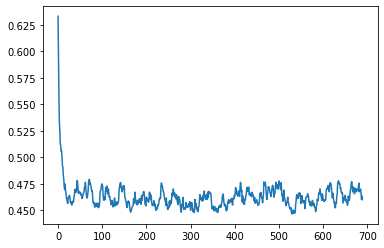

In [341]:
sns.lineplot(loss_vector)

ike you did for the numpy code, train your model for a total of 1000 steps (i.e., only
showing it 1000 randomly sampled documents) and report the loss after each 50 steps. This
should verify that the loss is going down

In [328]:
model = LogisticRegression(input_dim= T.shape[1],
                            output_dim= 1)

# define loss function
criterion = nn.BCELoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)

T = dok_matrix((len(train), len(train_vocab)), dtype=int)

for i in tqdm(range(len(train))):
    #get the text for specific row
    text_set = set(train.text.loc[i])

    for j in range(len(train_vocab)):

        word = train_vocab[j]
        if word in text_set:

            T[i, j] += 1    # Update element


T = to_sparse_tensor(T)

dev_matrix = dok_matrix((len(dev), len(train_vocab)), dtype = np.int64)
for i in range(len(dev)):
    text = dev.iloc[i,0]
    list_of_words = better_tokenize(text)
    for word in list_of_words:
        if word in train_vocab:
            dev_matrix[i,train_vocab.index(word)] +=1

dev_matrix = to_sparse_tensor(dev_matrix)
y = torch.Tensor(train.sarcastic)


loss_vector = []
f1_list = []
steps = 0
rng_jesus = np.arange(T.shape[0])
np.random.shuffle(rng_jesus)
for i in range(1000):
    steps+=1
    model.train()

    #random row
    index = rng_jesus[i]

    #data
    x_sample = T[index]
    y_sample = y[index]

    # zero gradients
    optimizer.zero_grad()

    #Forward pass
    y_hat = model(x_sample)



    #compute loss..
    loss = criterion(y_hat.squeeze(), y_sample)


    #Backward step
    loss.backward()

    if steps % 50 == 0:
        model.eval()

        with torch.no_grad():
            #append the loss vector
            #loss_vector.append(loss.item())
            y_hat = model(dev_matrix)
            loss = criterion(y_hat.squeeze(), torch.Tensor(dev.sarcastic))
            loss_vector.append(loss.item())
            f1_list.append(f1_score(y_hat.round().squeeze(), torch.Tensor(dev.sarcastic)))




    optimizer.step()
    # Update loss vector
        


100%|██████████| 3467/3467 [00:02<00:00, 1268.76it/s]


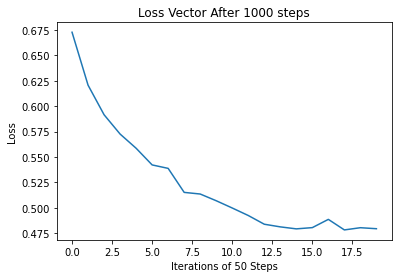

In [332]:
sns.lineplot(loss_vector)
plt.title('Loss Vector After 1000 steps')
plt.ylabel ('Loss')
plt.xlabel('Iterations of 50 Steps')
plt.show()

Once you’re satisfied that the model is working, train your model for at least 5 epochs and
compute (and save) both (1) the loss every 1000 steps and (2) the F1 score of the model on
the development data.

In [337]:
# let's get this thing up and running!
model = LogisticRegression(input_dim= T.shape[1],
                            output_dim= 1)

# define loss function
criterion = nn.BCELoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)

T = dok_matrix((len(train), len(train_vocab)), dtype=int)

for i in tqdm(range(len(train))):
    #get the text for specific row
    text_set = set(train.text.loc[i])

    for j in range(len(train_vocab)):

        word = train_vocab[j]
        if word in text_set:

            T[i, j] += 1    # Update element


T = to_sparse_tensor(T)

dev_matrix = dok_matrix((len(dev), len(train_vocab)), dtype = np.int64)
for i in range(len(dev)):
    text = dev.iloc[i,0]
    list_of_words = better_tokenize(text)
    for word in list_of_words:
        if word in train_vocab:
            dev_matrix[i,train_vocab.index(word)] +=1

dev_matrix = to_sparse_tensor(dev_matrix)
y = torch.Tensor(train.sarcastic)
loss_vector = []
f1_list = []
for i in tqdm(range(5)):

    steps = 0
    rng_jesus = np.arange(T.shape[0])
    np.random.shuffle(rng_jesus)
    for i in range(1000):
        steps+=1
        model.train()

        #random row
        index = rng_jesus[i]

        #data
        x_sample = T[index]
        y_sample = y[index]

        # zero gradients
        optimizer.zero_grad()

        #Forward pass
        y_hat = model(x_sample)



        #compute loss..
        loss = criterion(y_hat.squeeze(), y_sample)


        #Backward step
        loss.backward()

        if steps % 50 == 0:
            model.eval()

            with torch.no_grad():
                #append the loss vector
                #loss_vector.append(loss.item())
                y_hat = model(dev_matrix)
                loss = criterion(y_hat.squeeze(), torch.Tensor(dev.sarcastic))
                loss_vector.append(loss.item())
                f1_list.append(f1_score(y_hat.round().squeeze(), torch.Tensor(dev.sarcastic)))




        optimizer.step()
        # Update loss vector
        


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


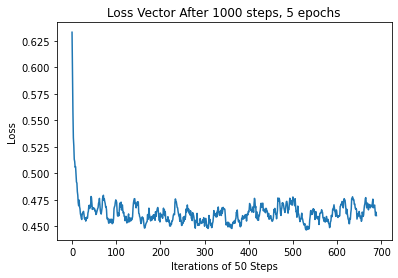

In [342]:
sns.lineplot(loss_vector)
plt.title('Loss Vector After 1000 steps, 5 epochs')
plt.ylabel ('Loss')
plt.xlabel('Iterations of 50 Steps')
plt.show()

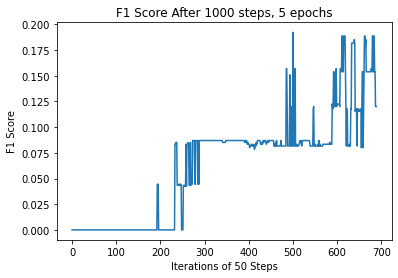

In [343]:
sns.lineplot(f1_list)
plt.title('F1 Score After 1000 steps, 5 epochs')
plt.ylabel ('F1 Score')
plt.xlabel('Iterations of 50 Steps')
plt.show()

Let’s see what are the effects of adding regularization. PyTorch builds in regularization
through the weight decay argument to most Optimizer classes (including the one you
use, SGD. Let’s see what the effect is for setting the L2 penalty to 0 (default), 0.001, and 0.1.
For each L2 penalty value, train the model for 1 epoch total and plot the loss and F1 score
on the development set every 50 steps using one line for each L2 value (use separate plots
for F1 vs. Loss). In a few sentences, describe what you see: What effect does L2 have on
the convergence speed and overall model performance?

In [387]:
# let's get this thing up and running!
model = LogisticRegression(input_dim= T.shape[1],
                            output_dim= 1)

# define loss function
criterion = nn.BCELoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2, weight_decay= 0.001)

loss_vector_0001 = []
f1_list_0001 = []


steps = 0
rng_jesus = np.arange(T.shape[0])
np.random.shuffle(rng_jesus)
for i in range(T.shape[0]):
    steps+=1
    model.train()

    #random row
    index = rng_jesus[i]

    #data
    x_sample = T[index]
    y_sample = y[index]

    # zero gradients
    optimizer.zero_grad()

    #Forward pass
    y_hat = model(x_sample)



    #compute loss..
    loss = criterion(y_hat.squeeze(), y_sample)


    #Backward step
    loss.backward()

    if steps % 50 == 0:
        model.eval()

        with torch.no_grad():
            #append the loss vector
            #loss_vector.append(loss.item())
            y_hat = model(dev_matrix)
            loss = criterion(y_hat.squeeze(), torch.Tensor(dev.sarcastic))
            loss_vector_0001.append(loss.item())
            f1_list_0001.append(f1_score(y_hat.round().squeeze(), torch.Tensor(dev.sarcastic)))




    optimizer.step()
    # Update loss vector
    


In [388]:
# let's get this thing up and running!
model = LogisticRegression(input_dim= T.shape[1],
                            output_dim= 1)

# define loss function
criterion = nn.BCELoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2, weight_decay= 0)

loss_vector_0 = []
f1_list_0 = []


steps = 0
rng_jesus = np.arange(T.shape[0])
np.random.shuffle(rng_jesus)
for i in range(T.shape[0]):
    steps+=1
    model.train()

    #random row
    index = rng_jesus[i]

    #data
    x_sample = T[index]
    y_sample = y[index]

    # zero gradients
    optimizer.zero_grad()

    #Forward pass
    y_hat = model(x_sample)



    #compute loss..
    loss = criterion(y_hat.squeeze(), y_sample)


    #Backward step
    loss.backward()

    if steps % 50 == 0:
        model.eval()

        with torch.no_grad():
            #append the loss vector
            #loss_vector.append(loss.item())
            y_hat = model(dev_matrix)
            loss = criterion(y_hat.squeeze(), torch.Tensor(dev.sarcastic))
            loss_vector_0.append(loss.item())
            f1_list_0.append(f1_score(y_hat.round().squeeze(), torch.Tensor(dev.sarcastic)))




    optimizer.step()
    # Update loss vector
    


In [389]:
# let's get this thing up and running!
model = LogisticRegression(input_dim= T.shape[1],
                            output_dim= 1)

# define loss function
criterion = nn.BCELoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2, weight_decay= 0.1)


loss_vector_01 = []
f1_list_01 = []


steps = 0
rng_jesus = np.arange(T.shape[0])
np.random.shuffle(rng_jesus)
for i in range(T.shape[0]):
    steps+=1
    model.train()

    #random row
    index = rng_jesus[i]

    #data
    x_sample = T[index]
    y_sample = y[index]

    # zero gradients
    optimizer.zero_grad()

    #Forward pass
    y_hat = model(x_sample)



    #compute loss..
    loss = criterion(y_hat.squeeze(), y_sample)


    #Backward step
    loss.backward()

    if steps % 50 == 0:
        model.eval()

        with torch.no_grad():
            #append the loss vector
            #loss_vector.append(loss.item())
            y_hat = model(dev_matrix)
            loss = criterion(y_hat.squeeze(), torch.Tensor(dev.sarcastic))
            loss_vector_01.append(loss.item())
            f1_list_01.append(f1_score(y_hat.round().squeeze(), torch.Tensor(dev.sarcastic)))




    optimizer.step()
    # Update loss vector
    


69

In [393]:
decay_df = pd.DataFrame()

decay_df['Loss'] = (loss_vector_0 + loss_vector_01 + loss_vector_0001)
decay_df['F1'] = f1_list_0 + f1_list_01 + f1_list_0001
decay_df['Decay'] = ["0"] * 69 + ["0.1"] * 69 + ['0.001'] * 69
decay_df['Iter'] = list(range(69)) * 3
decay_df.head()

,Loss,F1,Decay,Iter
0,0.652708,0.0,0,0
1,0.613423,0.0,0,1
2,0.575095,0.0,0,2
3,0.556834,0.0,0,3
4,0.535353,0.0,0,4


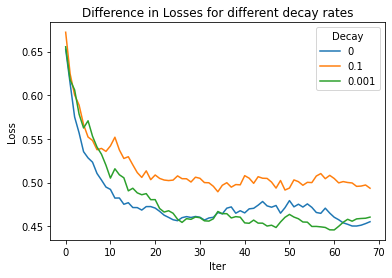

In [394]:
(sns.lineplot(data = decay_df, x = "Iter", y = "Loss" , hue = "Decay")
        .set_title('Difference in Losses for different decay rates'))
plt.show()

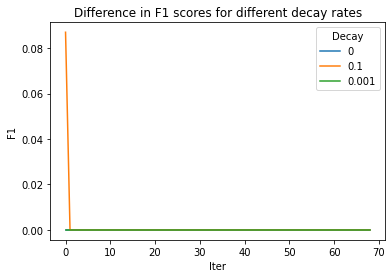

In [395]:
(sns.lineplot(data = decay_df, x = "Iter", y = "F1" , hue = "Decay")
        .set_title('Difference in F1 scores for different decay rates'))
plt.show()

PyTorch has more than just the SGD optimizer. Recall that SGD takes a step with respect
to the gradient using the learning rate to scale how big of a step to take. But what if we
11
used more than just the gradient? For example, could we keep a bit of momentum to keep
our gradient heading in the same direction? Many new optimizers have been proposed and
PyTorch keeps implementations of the more successful ones. The big benefit of a better
optimizer is that it helps the model learn faster. Since some of our big models may take
hours to converge, having the optimizer reduce the training time to under an hour can be a
huge time and environmental benefit. For this step, replace your SGD optimizer with two
other common alternatives RMSprop and AdamW. For each optimizer, train the model for 1
epoch total and plot the loss and F1 score on the development set every 50 steps using one
line per optimizer (use separate plots for F1 vs. Loss). In a few sentences, describe what
you see: What effect does the choice in optimizer have on the convergence speed and overall
model performance?

In [396]:
# let's get this thing up and running!
model = LogisticRegression(input_dim= T.shape[1],
                            output_dim= 1)

# define loss function
criterion = nn.BCELoss()

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-2 )

loss_vector_adamw = []
f1_list_adamw = []


steps = 0
rng_jesus = np.arange(T.shape[0])
np.random.shuffle(rng_jesus)
for i in range(T.shape[0]):
    steps+=1
    model.train()

    #random row
    index = rng_jesus[i]

    #data
    x_sample = T[index]
    y_sample = y[index]

    # zero gradients
    optimizer.zero_grad()

    #Forward pass
    y_hat = model(x_sample)



    #compute loss..
    loss = criterion(y_hat.squeeze(), y_sample)


    #Backward step
    loss.backward()

    if steps % 50 == 0:
        model.eval()

        with torch.no_grad():
            #append the loss vector
            #loss_vector.append(loss.item())
            y_hat = model(dev_matrix)
            loss = criterion(y_hat.squeeze(), torch.Tensor(dev.sarcastic))
            loss_vector_adamw.append(loss.item())
            f1_list_adamw.append(f1_score(y_hat.round().squeeze(), torch.Tensor(dev.sarcastic)))




    optimizer.step()
    # Update loss vector
    


In [397]:
# let's get this thing up and running!
model = LogisticRegression(input_dim= T.shape[1],
                            output_dim= 1)

# define loss function
criterion = nn.BCELoss()

# define optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr = 1e-2 )

loss_vector_rmsprop = []
f1_list_rmsprop = []


steps = 0
rng_jesus = np.arange(T.shape[0])
np.random.shuffle(rng_jesus)
for i in range(T.shape[0]):
    steps+=1
    model.train()

    #random row
    index = rng_jesus[i]

    #data
    x_sample = T[index]
    y_sample = y[index]

    # zero gradients
    optimizer.zero_grad()

    #Forward pass
    y_hat = model(x_sample)



    #compute loss..
    loss = criterion(y_hat.squeeze(), y_sample)


    #Backward step
    loss.backward()

    if steps % 50 == 0:
        model.eval()

        with torch.no_grad():
            #append the loss vector
            #loss_vector.append(loss.item())
            y_hat = model(dev_matrix)
            loss = criterion(y_hat.squeeze(), torch.Tensor(dev.sarcastic))
            loss_vector_rmsprop.append(loss.item())
            f1_list_rmsprop.append(f1_score(y_hat.round().squeeze(), torch.Tensor(dev.sarcastic)))




    optimizer.step()
    # Update loss vector
    


In [399]:
optim_df = pd.DataFrame()

optim_df['Loss'] = (loss_vector_adamw + loss_vector_rmsprop )
optim_df['F1'] = f1_list_adamw + f1_list_rmsprop 
optim_df['optim'] = ["AdamW"] * 69 + ["RMSProp"] * 69 
optim_df['Iter'] = list(range(69)) * 2
optim_df.head()

,Loss,F1,optim,Iter
0,0.590345,0.0,AdamW,0
1,0.519855,0.0,AdamW,1
2,0.504871,0.0,AdamW,2
3,0.481034,0.0,AdamW,3
4,0.477061,0.0,AdamW,4


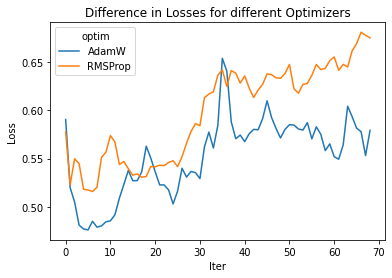

In [439]:
(sns.lineplot(data = optim_df, x = "Iter", y = "Loss" , hue = "optim")
        .set_title('Difference in Losses for different Optimizers'))
plt.show()

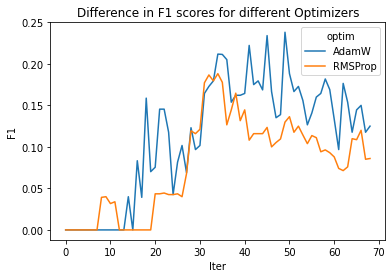

In [438]:
(sns.lineplot(data = optim_df, x = "Iter", y = "F1" , hue = "optim")
        .set_title('Difference in F1 scores for different Optimizers'))
plt.show()

We had two methods for tokenizing. Does one method perform better in practice here? Train
your model in the basic setting (using SGD, no L2 loss) for 1 epoch and plot the loss and F1
score on the development set every 50 steps using one line per optimizer (use separate plots
for F1 vs. Loss). In a few sentences, describe what you see: what effect does tokenization
have on the overall model performance?

In [403]:
# better tokenize
model = LogisticRegression(input_dim= T.shape[1],
                            output_dim= 1)

# define loss function
criterion = nn.BCELoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2 )

loss_vector_better_token = []
f1_list_better_token = []


steps = 0
rng_jesus = np.arange(T.shape[0])
np.random.shuffle(rng_jesus)
for i in range(T.shape[0]):
    steps+=1
    model.train()

    #random row
    index = rng_jesus[i]

    #data
    x_sample = T[index]
    y_sample = y[index]

    # zero gradients
    optimizer.zero_grad()

    #Forward pass
    y_hat = model(x_sample)



    #compute loss..
    loss = criterion(y_hat.squeeze(), y_sample)


    #Backward step
    loss.backward()

    if steps % 50 == 0:
        model.eval()

        with torch.no_grad():
            #append the loss vector
            #loss_vector.append(loss.item())
            y_hat = model(dev_matrix)
            loss = criterion(y_hat.squeeze(), torch.Tensor(dev.sarcastic))
            loss_vector_better_token.append(loss.item())
            f1_list_better_token.append(f1_score(y_hat.round().squeeze(), torch.Tensor(dev.sarcastic)))




    optimizer.step()
    # Update loss vector
    


In [427]:


new_train = pd.read_csv('si630w23-hw1.train.csv')
new_train.text = new_train.text.apply(tokenize)
train_vocab_all_single_token = functools.reduce(operator.iconcat, 
                list(new_train.text), [])


c = Counter(train_vocab_all_single_token)
to_remove = {x for x, i in c.items() if i < 2}
train_vocab_single = list(set(train_vocab_all_single_token) - to_remove)
len(train_vocab_single)

Q = dok_matrix((len(new_train), len(train_vocab_single)), dtype=int)

for i in tqdm(range(len(new_train))):
    #get the text for specific row
    text_set = set(new_train.text.loc[i])

    for j in range(len(train_vocab_single)):

        word = train_vocab_single[j]
        if word in text_set:

            Q[i, j] += 1    # Update element
    

Q = to_sparse_tensor(Q)

# let's get this thing up and running!
model = LogisticRegression(input_dim= Q.shape[1],
                            output_dim= 1)

# define loss function
criterion = nn.BCELoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2,


dev_matrix_tokenize = dok_matrix((len(dev), len(train_vocab_single)), dtype = np.int64)
for i in range(len(dev)):
    text = dev.iloc[i,0]
    list_of_words = tokenize(text)
    for word in list_of_words:
        if word in train_vocab_single:
            dev_matrix_tokenize[i,train_vocab_single.index(word)] +=1

dev_matrix_tokenize = to_sparse_tensor(dev_matrix_tokenize)

loss_vector_tokenize = []
f1_list_tokenize = []


steps = 0
rng_jesus = np.arange(Q.shape[0])
np.random.shuffle(rng_jesus)
for i in range(Q.shape[0]):
    steps+=1
    model.train()

    #random row
    index = rng_jesus[i]

    #data
    x_sample = Q[index]
    y_sample = y[index]

    # zero gradients
    optimizer.zero_grad()

    #Forward pass
    y_hat = model(x_sample)



    #compute loss..
    loss = criterion(y_hat.squeeze(), y_sample)


    #Backward step
    loss.backward()

    if steps % 50 == 0:
        model.eval()

        with torch.no_grad():
            #append the loss vector
            #loss_vector.append(loss.item())
            y_hat = model(dev_matrix_tokenize)
            loss = criterion(y_hat.squeeze(), torch.Tensor(dev.sarcastic))
            loss_vector_tokenize.append(loss.item())
            f1_list_tokenize.append(f1_score(y_hat.round().squeeze(), torch.Tensor(dev.sarcastic)))




    optimizer.step()
    # Update loss vector

100%|██████████| 3467/3467 [00:03<00:00, 1020.04it/s]


In [441]:
tokenize_df = pd.DataFrame()

tokenize_df['Loss'] = (loss_vector_tokenize + loss_vector_better_token )
tokenize_df['F1'] = f1_list_tokenize + f1_list_better_token 
tokenize_df['Method'] = ["Tokenize"] * 69 + ["Better Tokenize"] * 69 
tokenize_df['Iter'] = list(range(69)) * 2
tokenize_df.head()

,Loss,F1,Method,Iter
0,0.602702,0.0,Tokenize,0
1,0.566541,0.0,Tokenize,1
2,0.554477,0.0,Tokenize,2
3,0.545514,0.0,Tokenize,3
4,0.553126,0.0,Tokenize,4


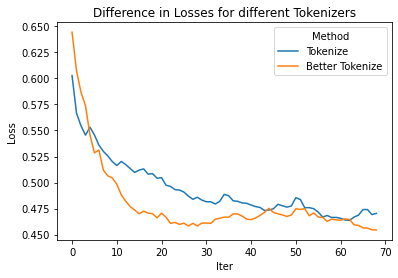

In [442]:
(sns.lineplot(data = tokenize_df, x = "Iter", y = "Loss", hue= "Method" )
        .set_title('Difference in Losses for different Tokenizers'))
plt.show()

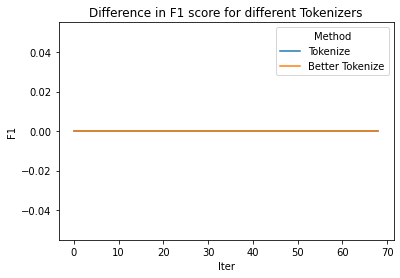

In [443]:
(sns.lineplot(data = tokenize_df, x = "Iter", y = "F1", hue= "Method" )
        .set_title('Difference in F1 score for different Tokenizers'))
plt.show()

What effect does the learning rate have on our model’s convergence? Using the basic setup
with SGD, change the lr argument (i.e., learning rate) to a much larger and much smaller
value and for 1 epoch and plot the loss and F1 score on the development set every 50 steps
using one line per lr value. Plot all three curves together and describe what you observe:
what effect does the learning rate have on the model’s convergence speed? You’re welcome
(encouraged, even!) to try additional learning rates. If your model converges quickly, you
can also reduce the number of steps between evaluation for this question.

In [445]:

model = LogisticRegression(input_dim= T.shape[1],
                            output_dim= 1)

# define loss function
criterion = nn.BCELoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1 )

loss_vector_1e1 = []
f1_list_1e1 = []


steps = 0
rng_jesus = np.arange(T.shape[0])
np.random.shuffle(rng_jesus)
for i in range(T.shape[0]):
    steps+=1
    model.train()

    #random row
    index = rng_jesus[i]

    #data
    x_sample = T[index]
    y_sample = y[index]

    # zero gradients
    optimizer.zero_grad()

    #Forward pass
    y_hat = model(x_sample)



    #compute loss..
    loss = criterion(y_hat.squeeze(), y_sample)


    #Backward step
    loss.backward()

    if steps % 50 == 0:
        model.eval()

        with torch.no_grad():
            #append the loss vector
            #loss_vector.append(loss.item())
            y_hat = model(dev_matrix)
            loss = criterion(y_hat.squeeze(), torch.Tensor(dev.sarcastic))
            loss_vector_1e1.append(loss.item())
            f1_list_1e1.append(f1_score(y_hat.round().squeeze(), torch.Tensor(dev.sarcastic)))




    optimizer.step()
    # Update loss vector
    


In [447]:
# let's get this thing up and running!
model = LogisticRegression(input_dim= T.shape[1],
                            output_dim= 1)

# define loss function
criterion = nn.BCELoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3 )

loss_vector_1e3 = []
f1_list_1e3 = []


steps = 0
rng_jesus = np.arange(T.shape[0])
np.random.shuffle(rng_jesus)
for i in range(T.shape[0]):
    steps+=1
    model.train()

    #random row
    index = rng_jesus[i]

    #data
    x_sample = T[index]
    y_sample = y[index]

    # zero gradients
    optimizer.zero_grad()

    #Forward pass
    y_hat = model(x_sample)



    #compute loss..
    loss = criterion(y_hat.squeeze(), y_sample)


    #Backward step
    loss.backward()

    if steps % 50 == 0:
        model.eval()

        with torch.no_grad():
            #append the loss vector
            #loss_vector.append(loss.item())
            y_hat = model(dev_matrix)
            loss = criterion(y_hat.squeeze(), torch.Tensor(dev.sarcastic))
            loss_vector_1e3.append(loss.item())
            f1_list_1e3.append(f1_score(y_hat.round().squeeze(), torch.Tensor(dev.sarcastic)))




    optimizer.step()
    # Update loss vector
    


In [449]:
lr_df = pd.DataFrame()

lr_df['Loss'] = (loss_vector_0 + loss_vector_1e1 + loss_vector_1e3 )
lr_df['F1'] = f1_list_0 + f1_list_1e1 + f1_list_1e3
lr_df['Learning Rate'] = ["1e-2"] * 69 + ["1e-1"] * 69 + ["1e-3"]*69
lr_df['Iter'] = list(range(69)) * 3
lr_df.head()

,Loss,F1,Learning Rate,Iter
0,0.652708,0.0,1e-2,0
1,0.613423,0.0,1e-2,1
2,0.575095,0.0,1e-2,2
3,0.556834,0.0,1e-2,3
4,0.535353,0.0,1e-2,4


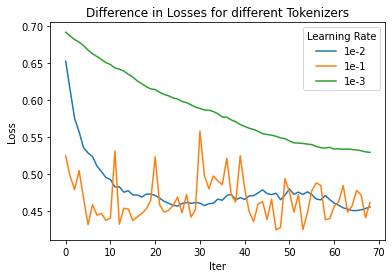

In [450]:
(sns.lineplot(data = lr_df, x = "Iter", y = "Loss", hue= "Learning Rate" )
        .set_title('Difference in Losses for different Tokenizers'))
plt.show()

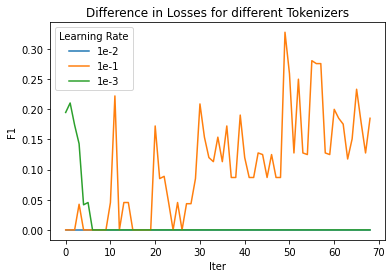

In [451]:
(sns.lineplot(data = lr_df, x = "Iter", y = "F1", hue= "Learning Rate" )
        .set_title('Difference in Losses for different Tokenizers'))
plt.show()

Finally, use your best model to generate prediction results and report the final F1 score. Don’t
forget to upload your prediction results on Kaggle. Note that this is a separate competition
so that you can compare your scores with the numpy version

In [ ]:
# my two favorite models were the AdamW lr = 1e-2, SGD lr = 1e-1. Let's compare those f1 scores.

In [453]:
final_comp_df = pd.DataFrame()

final_comp_df['Loss'] = (loss_vector_adamw + loss_vector_1e1)
final_comp_df['F1'] = f1_list_adamw + f1_list_1e1 
final_comp_df['Params'] = ["AdamW, 1e-2"] * 69 + ["SGD, 1e-1"] * 69 
final_comp_df['Iter'] = list(range(69)) * 2
final_comp_df.head()

,Loss,F1,Params,Iter
0,0.590345,0.0,"AdamW, 1e-2",0
1,0.519855,0.0,"AdamW, 1e-2",1
2,0.504871,0.0,"AdamW, 1e-2",2
3,0.481034,0.0,"AdamW, 1e-2",3
4,0.477061,0.0,"AdamW, 1e-2",4


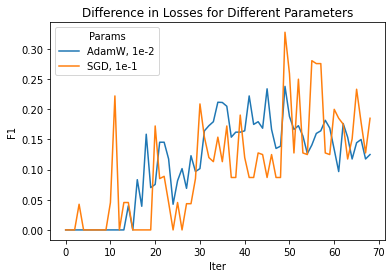

In [455]:
(sns.lineplot(data = final_comp_df, x = "Iter", y = "F1", hue= "Params" )
        .set_title('Difference in Losses for Different Parameters'))
plt.show()

They're pretty close, but I prefer the SGD with the 1e-1 learning rate. That is overall higher than the AdamW one.

Time to make the predictions! 

In [457]:

test = pd.read_csv('si630w23-hw1.test.csv')
test.head()

,text
0,"Size on the the Toulouse team, That pack is mo..."
1,Pinball!
2,So the Scottish Government want people to get ...
3,villainous pro tip : change the device name on...
4,I would date any of these men 🥺


In [458]:
test_matrix = dok_matrix((len(test), len(train_vocab)), dtype = np.int64)
for i in range(len(test)):
    text = test.iloc[i,0]
    list_of_words = better_tokenize(text)
    for word in list_of_words:
        if word in train_vocab:
            test_matrix[i,train_vocab.index(word)] +=1

test_matrix = to_sparse_tensor(test_matrix)

model = LogisticRegression(input_dim= T.shape[1],
                            output_dim= 1)

# define loss function
criterion = nn.BCELoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1 )


y_hat = model(test_matrix)



In [462]:
test_predictions = [1 if word >= 0.5 else 0 for word in y_hat]


In [470]:
test_preds = pd.DataFrame()
test_preds['Index'] = list(range(len(test_predictions)))
test_preds['prediction'] = test_predictions
test_preds.to_csv('test_predictions.csv')